In [262]:
import numpy as np
import matplotlib.pyplot as plt
from wave_tracing_FE import Wave_tracing_FE
from scipy.stats import norm
import cmocean

%matplotlib inline

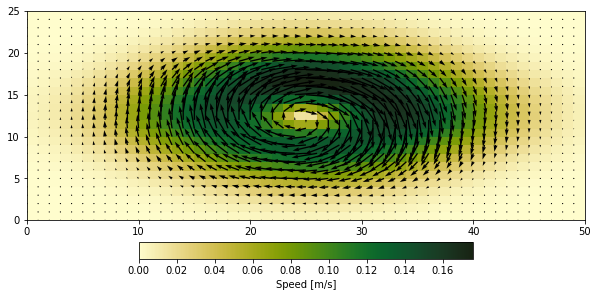

In [280]:
# A theoretical eddy
nx, ny = (50, 25)
x = np.linspace(-1, 0, nx)
y = np.linspace(0, 1, ny)
xv, yv = np.meshgrid(x, y)
u = np.pi*np.sin(np.pi*xv)*np.cos(np.pi*yv)
v = -np.pi*np.cos(np.pi*xv)*np.sin(np.pi*yv)

# weighten with a bell curve
x_weight = norm.pdf(np.arange(-3, 3, 6/nx),0,1)
y_weight = norm.pdf(np.arange(-3, 3, 6/ny),0,1)

#u/=np.pi
#v/=np.pi

for idx in range(u.shape[0]):
    u[idx,:] *= x_weight
    v[idx,:] *= x_weight

for idy in range(u.shape[1]):
    u[:,idy] *= y_weight
    v[:,idy] *= y_weight

#u*=x_weight
#v*=x_weight



fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,5))
pc0 = ax.pcolormesh(np.sqrt(u**2 + v**2),cmap=cmocean.cm.speed)
ax.quiver(u,v)
fig.colorbar(pc0,ax=ax,orientation='horizontal',shrink=0.6,pad=0.08,label="Speed [m/s]")

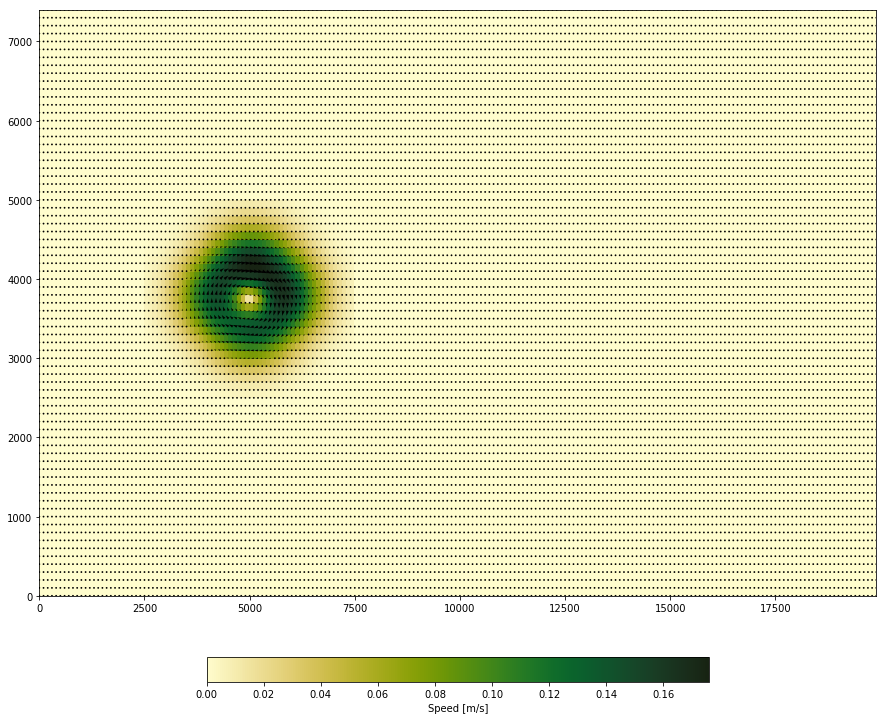

In [281]:
# Insert theoretical eddy in larger domain
dx=dy=100 #m

nny, nnx = (200,75)
xx = np.arange(nnx)*dx
yy = np.arange(nny)*dy
uu = np.zeros((nnx,nny))
vv = uu.copy()

uu[25:50,25:75] = u
#uu[50:62,25:75] = np.flipud(u[-13:-1,:]) #u[0:12,:]
#uu[13:25,25:75] = np.flipud(u[0:12,:])#u[-13:-1,:]


vv[25:50,25:75] = v
#vv[25:50,75:100] = np.fliplr(v[:,-25:])
#vv[25:50,0:25] = np.fliplr(v[:,0:25])#v[:,-25:]


speed = np.sqrt(uu**2 + vv**2)

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(15,14))
pc0 = ax.pcolormesh(yy,xx,speed,cmap=cmocean.cm.speed)
ax.quiver(yy,xx,uu,vv,scale=25, scale_units='width')
fig.colorbar(pc0,ax=ax,orientation='horizontal',shrink=0.6,pad=0.08,label="Speed [m/s]")

In [306]:
# Compute the wave rays

nb_wave_rays = nnx 

T = 2500
print("T={}h".format(T/3600))
nt = 3000
wave_period = 10
theta0 = 0

X0, XN = xx[0], yy[-1]
Y0, YN = yy[0], xx[-1]

wt = Wave_tracing_FE(uu, vv, nny, nnx, nt,T,dx,dy, wave_period, theta0,nb_wave_rays=nb_wave_rays,
                domain_X0=X0, domain_XN=XN,
                domain_Y0=Y0, domain_YN=YN)

wt.set_initial_condition()
wt.solve()

x_rd,y_rd,hm = wt.ray_density(5,5)

T=0.6944444444444444h


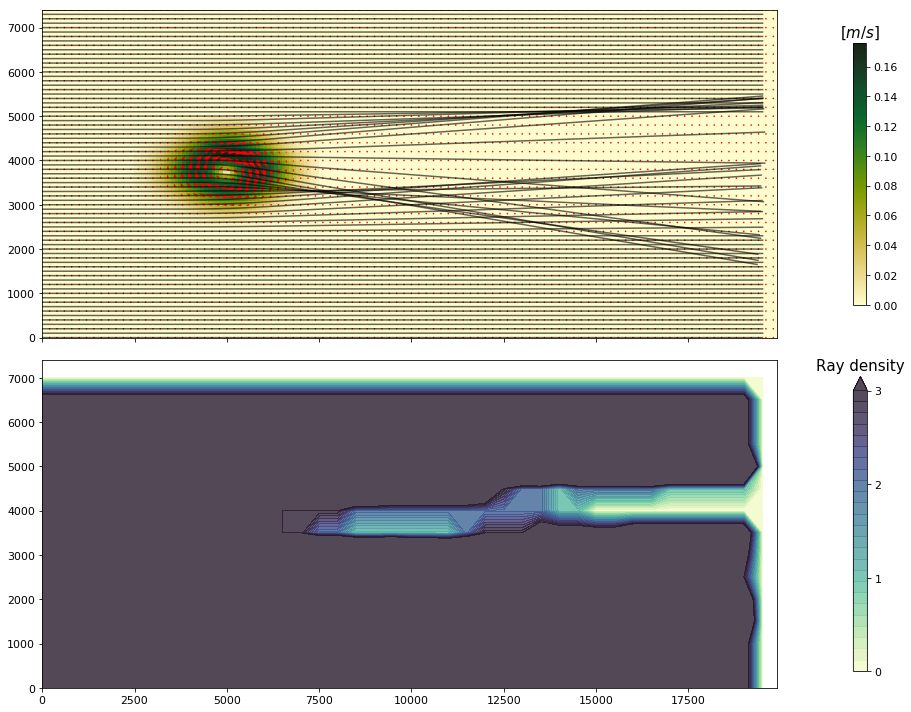

In [307]:
# PLOTTING
fs=15
fig,ax = plt.subplots(nrows=2,figsize=(14,10),sharex=True,sharey=True)
pc=ax[0].pcolormesh(yy,xx,speed,cmap=cmocean.cm.speed)
qu=ax[0].quiver(yy[::2],xx[::2],uu[::2,::2],vv[::2,::2],color='r', scale=12)

for i in range(0,wt.nb_wave_rays):
    ax[0].plot(wt.xr[i,:],wt.yr[i,:],'-k',alpha=0.6)
ax[0].set_xlim([X0,XN])
ax[0].set_ylim([Y0,YN])

levels = np.linspace(0,3,26)
density = ax[1].contourf(x_rd,y_rd,hm,extend='max',
                         cmap=cmocean.cm.deep,alpha=0.8, levels=levels)



cb0 = fig.colorbar(pc,ax=ax[0],orientation='vertical',extend='neither',shrink=0.8, pad=0.08)
cb0.ax.set_title(r'$[m/s]$',fontsize=fs)
cb1 = fig.colorbar(density,ax=ax[1],orientation='vertical',shrink=0.9, pad=0.08, ticks=[0, 1, 2, 3, 4, 5 ])
cb1.ax.set_title(r'Ray density',fontsize=fs)

fig.tight_layout()
ax[0].tick_params(axis='both',labelsize=fs-4)
ax[1].tick_params(axis='both',labelsize=fs-4)
cb0.ax.tick_params(labelsize=fs-4)
cb1.ax.tick_params(labelsize=fs-4)